In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import numpy as np
from matplotlib import cm
from matplotlib.colors import Normalize

In [14]:
def format_ticks(y, _):
        # Format with 2 decimals
        s = f'{y:.3f}'
        # Remove trailing zeros and dot if needed
        if '.' in s:
            s = s.rstrip('0').rstrip('.')
        # Remove leading zero before decimal point
        if s.startswith('0.') or s.startswith('-0.'):
            s = s.replace('0.', '.')
        return s

In [17]:
gt_df_005 = pd.read_csv("/home/wollerf/Projects/GRN-FinDeR_Results.git/results/manuscript/groundtruth_variation/groundtruth_variation_results_005.csv", index_col=0)
gt_df_001 = pd.read_csv("/home/wollerf/Projects/GRN-FinDeR_Results.git/results/manuscript/groundtruth_variation/groundtruth_variation_results_001.csv", index_col=0)
approx_results_path = "../../results/manuscript/groundtruth_variation/random_100_targets_wasserstein_against_ten_groundtruths.csv"
approx_df = pd.read_csv(approx_results_path)
approx_df = approx_df[approx_df['tissue'].isin(['Breast', 'Testis', 'Kidney'])]

df_005 = gt_df_005[['gtA', 'gtB', 'f1', 'tissue']].rename(columns={'f1': 'f1_005'})

# Select and rename columns in gt_df_001
df_001 = gt_df_001[['gtA', 'gtB', 'f1', 'tissue']].rename(columns={'f1': 'f1_001'})

# Merge on gtA and gtB
merged_df = pd.merge(df_005, df_001, on=['gtA', 'gtB', 'tissue'])

merged_df = merged_df.rename(columns={'gtA': 'num_non_tfs', 'gtB': 'num_tfs'})
merged_df['mode'] = "groundtruth"
approx_df['mode'] = "approx"

total_df = pd.concat([merged_df, approx_df], ignore_index=True, sort=False)
total_df['tissue'] = total_df['tissue'].str.capitalize()
total_df['mode'] = total_df['mode'].replace({'approx': "Approximate vs. groundtruth", "groundtruth": "Groundtruth vs. groundtruth"})

/tmp/ipykernel_88304/4057284898.py:94: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['sample_bin', 'num_non_tfs'], as_index=False)
/tmp/ipykernel_88304/4057284898.py:104: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_labels = total_time_df.applymap(lambda x: f"{x:.1f}" if pd.notnull(x) else "")
/tmp/ipykernel_88304/4057284898.py:136: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['sample_bin', 'num_non_tfs'], as_index=False)


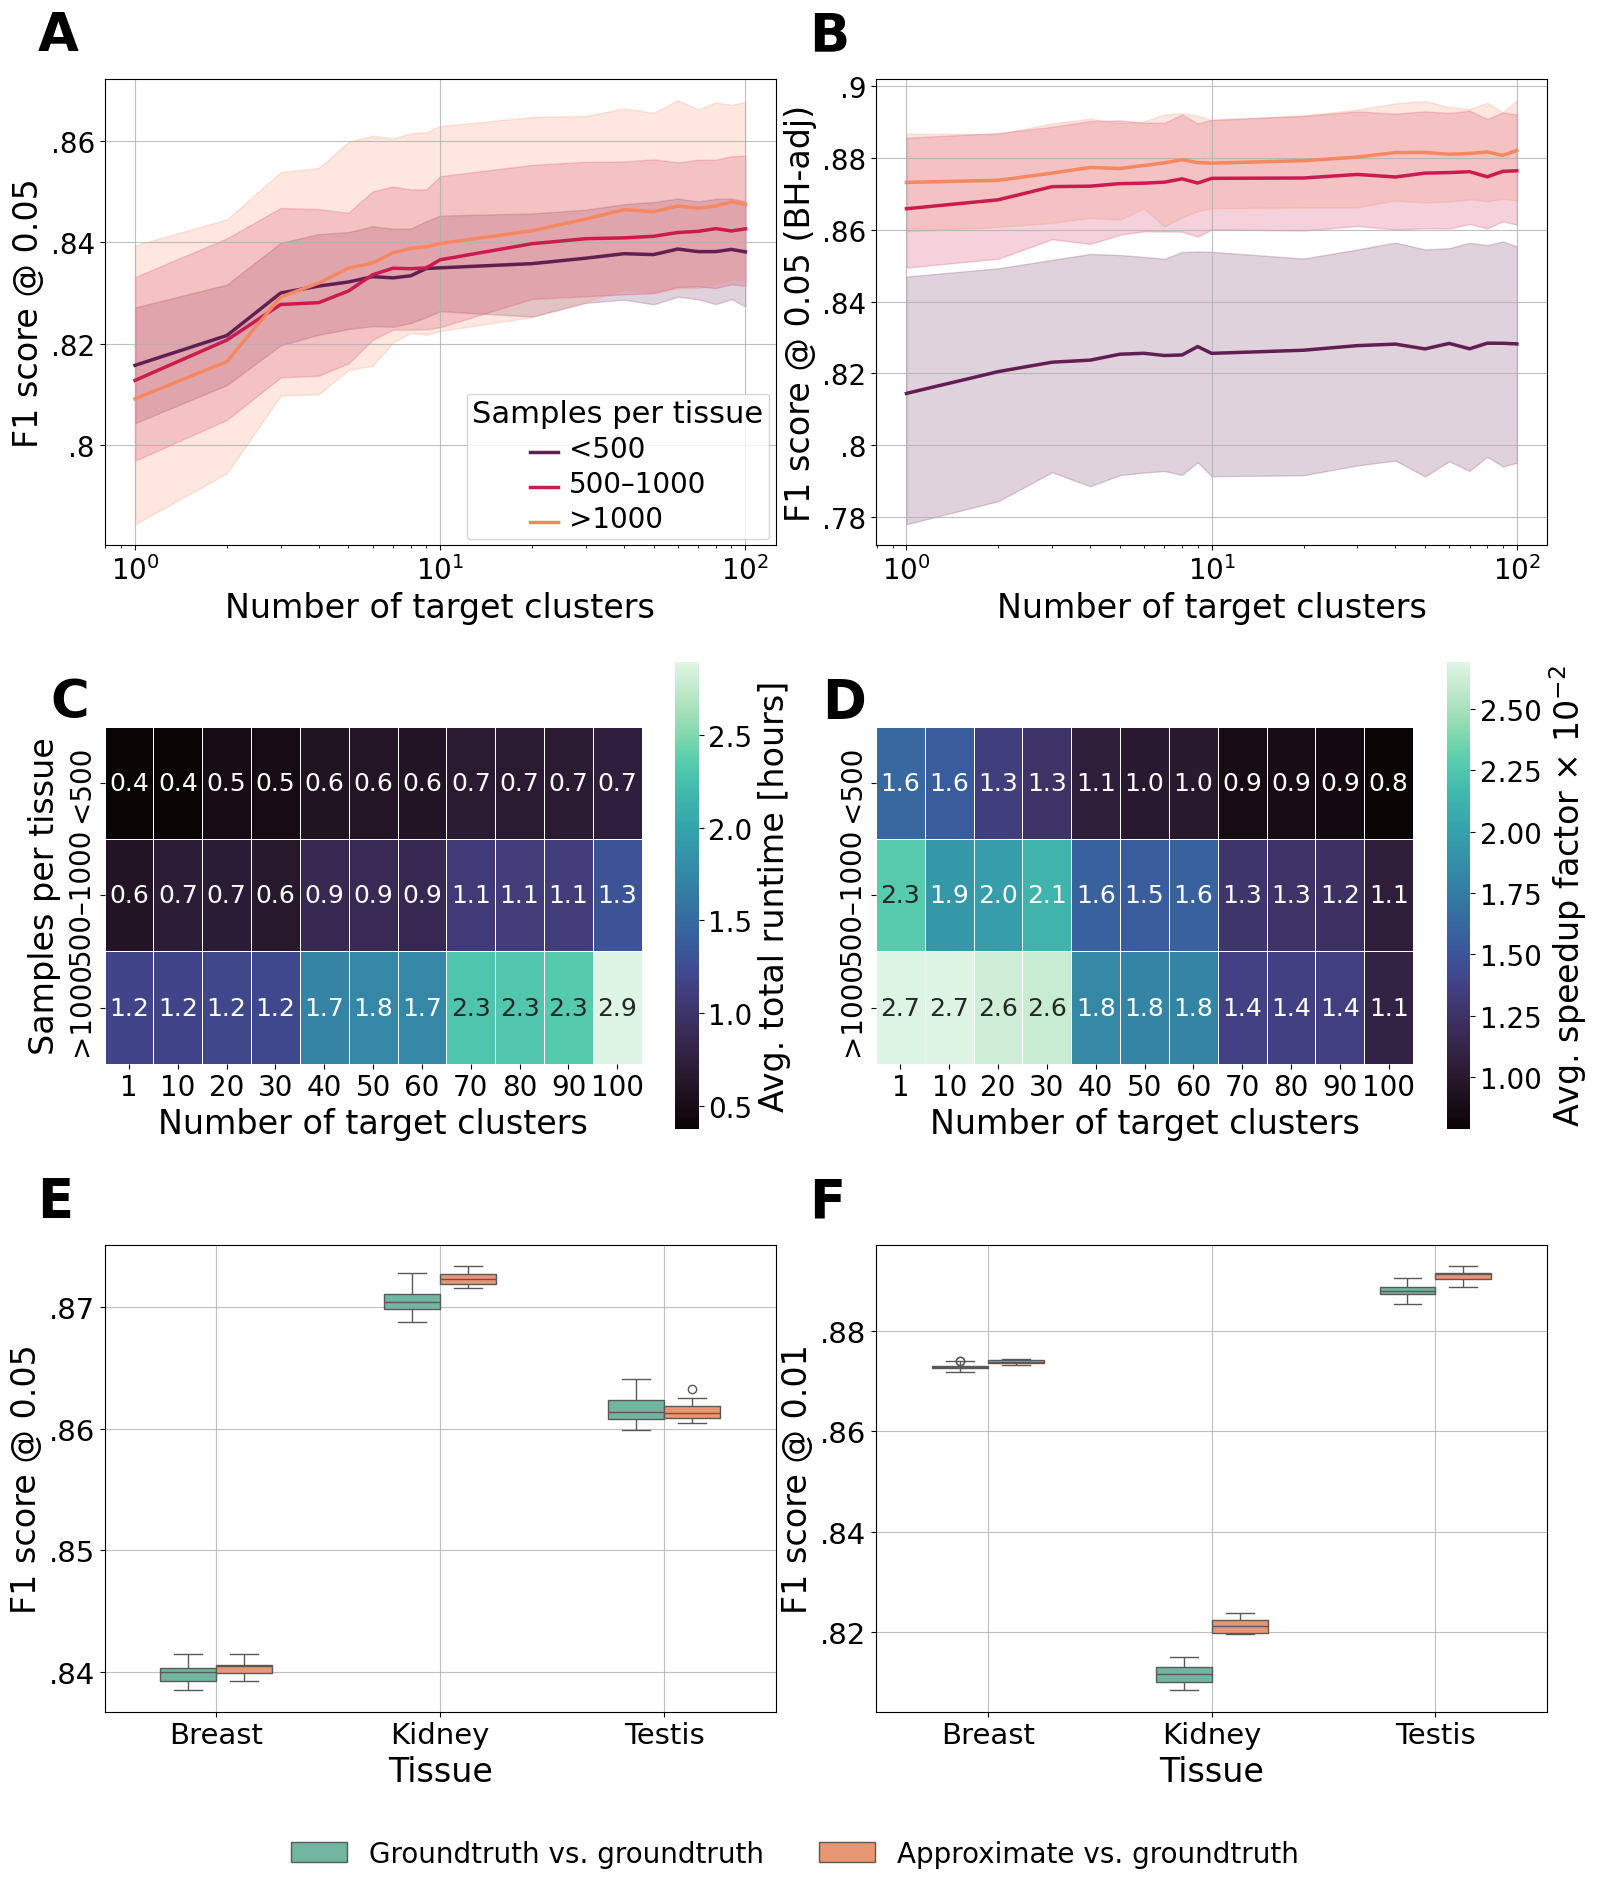

In [47]:
def plot_random_target_results(results_path : str):
    """Plots Figure containing gleason scores and OS time per 4.x cluster as well as xcell analysis 
    results.
    """
    # Load results df.
    results_df = pd.read_csv(results_path)
    results_df['num_samples_log'] = np.log(results_df["num_samples"])
    #results_df['num_samples'] = [x for x in results_df["num_samples"]]
    results_df['total_runtime'] = results_df['total_runtime']/3600.0
    results_df['abs_time_saving'] = results_df['abs_time_saving']/3600.0
    
    # Load BH-corrected results.
    bh_path = "../../results/manuscript/random_targets_wasserstein_benjamini_hb_all_tissues.csv"
    bh_df = pd.read_csv(bh_path)
    
    # Transfer samples column to BH df.
    tissue_sample_dict = dict()
    for index, row in results_df.iterrows():
        tissue_sample_dict[row['tissue']] = row['num_samples']
    bh_sample_col = []
    for tissue in bh_df['tissue']:
        bh_sample_col.append(tissue_sample_dict[tissue])
    bh_df['num_samples'] = bh_sample_col
    
    # Create one large mosaic plot.
    fig, axs = plt.subplot_mosaic([['A', 'A', 'B', 'B'], ['C', 'C', 'D', 'D'], ['E', 'E', 'F', 'F']])
    fig.set_size_inches(16, 18)
    axs_list = list(axs.values())
    label_fontsize = 24
    
    bins = [0, 500, 1000, float('inf')]
    labels = ['<500', '500–1000', '>1000']
    results_df['sample_bin'] = pd.cut(results_df['num_samples'], bins=bins, labels=labels, right=False)
    bh_df['sample_bin'] = pd.cut(bh_df['num_samples'], bins=bins, labels=labels, right=False)

    # Draw regression lines per bin
    line1 = sns.lineplot(
    data=results_df,
    x='num_non_tfs',
    y='f1_005',
    hue='sample_bin',
    ax=axs['A'],
    palette=sns.color_palette("rocket", 3)  ,
    linewidth=2.5
    #errorbar='sd',
    #err_style='bars'
    )
    line1.legend(title='Samples per tissue')
    axs['A'].set_xlabel('Number of target clusters', fontsize=label_fontsize)
    axs['A'].set_ylabel('F1 score @ 0.05', fontsize=label_fontsize)
    axs['A'].tick_params(axis='x', labelsize=label_fontsize-4)
    axs['A'].tick_params(axis='y', labelsize=label_fontsize-4)
    formatter = FuncFormatter(format_ticks)
    axs['A'].yaxis.set_major_formatter(formatter)
    axs['A'].grid(True, alpha=0.8)
    axs['A'].set_xscale('log')
    sns.move_legend(axs['A'], "lower right")#, bbox_to_anchor=(1.3, -0.38))
    plt.setp(axs['A'].get_legend().get_texts(), fontsize=label_fontsize-4)
    plt.setp(axs['A'].get_legend().get_title(), fontsize=label_fontsize-2)

    
    sns.lineplot(
    data=bh_df,
    x='num_non_tfs',
    y='f1_005',
    hue='sample_bin',
    ax=axs['B'],
    palette=sns.color_palette("rocket", 3)  ,
    linewidth=2.5,
    legend=False
    #errorbar='sd',
    #err_style='bars'
    )
    #axs['B'].set_title('Significance Level of 0.01', fontsize=label_fontsize)
    axs['B'].set_xlabel('Number of target clusters', fontsize=label_fontsize)
    axs['B'].set_ylabel('F1 score @ 0.05 (BH-adj)', fontsize=label_fontsize)
    axs['B'].tick_params(axis='x', labelsize=label_fontsize-4)
    axs['B'].tick_params(axis='y', labelsize=label_fontsize-4)
    formatter = FuncFormatter(format_ticks)
    # Apply to y-axis
    axs['B'].yaxis.set_major_formatter(formatter)
    axs['B'].grid(True, alpha=0.8)
    axs['B'].set_xscale('log')
    
    # --- Compute and aggregate speed-up factors ---
    results_df['speedup_factor_log10'] = results_df['rel_time_saving'] / 100
    
    # --- Filter x-values of interest ---
    subset = results_df[results_df['num_non_tfs'].isin([1,10,20,30,40,50,60,70,80,90,100])]

    # --- Aggregate runtime per bin and num_non_tfs ---
    runtime_df = (
        subset
        .groupby(['sample_bin', 'num_non_tfs'], as_index=False)
        ['total_runtime']
        .mean()
    )

    # --- Pivot to wide format for heatmap ---
    total_time_df = runtime_df.pivot(index='sample_bin', columns='num_non_tfs', values='total_runtime')
    total_time_df = total_time_df.sort_index().sort_index(axis=1)

    # --- Annotate heatmap with formatted labels ---
    annot_labels = total_time_df.applymap(lambda x: f"{x:.1f}" if pd.notnull(x) else "")

    # --- Plot first heatmap: total runtime ---
    heat1 = sns.heatmap(
        total_time_df,
        cmap="mako",
        linewidths=0.5,
        linecolor='white',
        annot=annot_labels,
        annot_kws={"size":label_fontsize-6},
    fmt='',
    cbar_kws={'label': 'Avg. total runtime [hours]'},
    ax=axs['C']
    )

    # --- Format colorbar and axes ---
    cbar = heat1.collections[0].colorbar
    cbar.ax.yaxis.label.set_size(label_fontsize)
    cbar.ax.tick_params(labelsize=label_fontsize - 4)

    axs['C'].set_xlabel('Number of target clusters', fontsize=label_fontsize)
    axs['C'].set_ylabel('Samples per tissue', fontsize=label_fontsize)
    axs['C'].tick_params(axis='x', labelsize=label_fontsize - 4)
    axs['C'].tick_params(axis='y', labelsize=label_fontsize - 4)
    
    axs['C'].set_aspect(aspect=2.3)

    # --- Compute and aggregate speed-up factors ---
    results_df['speedup_factor_log10'] = results_df['rel_time_saving'] / 100

    speedup_df = (
        subset
        .groupby(['sample_bin', 'num_non_tfs'], as_index=False)
        ['speedup_factor_log10']
        .mean()
    )

    # --- Pivot for second heatmap ---
    speedup_wide = speedup_df.pivot(index='sample_bin', columns='num_non_tfs', values='speedup_factor_log10')
    speedup_wide = speedup_wide.sort_index().sort_index(axis=1)

    # --- Plot second heatmap: speedup ---
    heat2 = sns.heatmap(
        speedup_wide,
        cmap="mako",
    linewidths=0.5,
    linecolor='white',
    annot=True,
    fmt=".1f",
    cbar_kws={'label': r'Avg. speedup factor × $10^{-2}$'},
    ax=axs['D'],
    annot_kws={"size":label_fontsize-6}
    )

    cbar = heat2.collections[0].colorbar
    cbar.ax.yaxis.label.set_size(label_fontsize)
    cbar.ax.tick_params(labelsize=label_fontsize - 4)

    axs['D'].set_xlabel('Number of target clusters', fontsize=label_fontsize)
    axs['D'].set_ylabel('', fontsize=label_fontsize)
    axs['D'].tick_params(axis='x', labelsize=label_fontsize - 4)
    axs['D'].tick_params(axis='y', labelsize=label_fontsize - 4)
    axs['D'].set_aspect(aspect=2.3)
    
    sns.boxplot(data=total_df, x='tissue', y='f1_005', hue="mode", ax=axs['E'], palette="Set2", width=0.5)
    axs['E'].set_xlabel('Tissue', fontsize=label_fontsize)
    axs['E'].set_ylabel('F1 score @ 0.05', fontsize=label_fontsize)
    axs['E'].tick_params(axis='x', labelsize=label_fontsize-3)
    axs['E'].tick_params(axis='y', labelsize=label_fontsize-3)
    axs['E'].yaxis.set_major_formatter(FuncFormatter(format_ticks))
    axs['E'].grid(True, alpha=0.8)

    # Plot B
    sns.boxplot(data=total_df, x='tissue', y='f1_001', hue="mode", ax=axs['F'], palette="Set2", width=0.5)
    axs['F'].set_xlabel('Tissue', fontsize=label_fontsize)
    axs['F'].set_ylabel('F1 score @ 0.01', fontsize=label_fontsize)
    axs['F'].tick_params(axis='x', labelsize=label_fontsize-3)
    axs['F'].tick_params(axis='y', labelsize=label_fontsize-3)
    axs['F'].yaxis.set_major_formatter(FuncFormatter(format_ticks))
    axs['F'].grid(True, alpha=0.8)

    # Remove individual legends
    axs['E'].legend_.remove()
    axs['F'].legend_.remove()

    # Create a shared legend below both plots
    handles, labels = axs['E'].get_legend_handles_labels()
    fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05),  # Push legend slightly below the figure
    ncol=len(labels),
    fontsize=20,
    frameon=False
    )
    
    labels = {'A': 'A', 'B': 'B', 'C': 'C', 'D': 'D', 'E':'E', 'F': 'F'}

    for key, label in labels.items():
        ax = axs[key]
        ax.text(
            -0.1, 1.15, label,  # x, y (in axes fraction coords)
            transform=ax.transAxes,
            fontsize=38,
            fontweight='bold',
            va='top',
            ha='left'
        )
    
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.25, wspace=0.35)
    #plt.show()
    plt.savefig("results_f1_time_random_targets_wasserstein.pdf", format='pdf', bbox_inches='tight')
    
results_path = "../../results/manuscript/random_targets_wasserstein_all_tissues_with_samples.csv"
plot_random_target_results(results_path)